In [2]:
import wave
import scipy as sp
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display
import os
from scipy.io.wavfile import write
import time
#import torch
#from torch.nn import functional as F
import glob
#import transformers
#import tensorflowjs as tfjs
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

2022-01-13 14:55:10.017022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [17]:
tf.__version__

'2.4.1'

In [3]:
gpu_id = 1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[gpu_id], 'GPU')

2022-01-13 14:55:17.230559: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-13 14:55:17.246212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-13 14:55:17.286493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-13 14:55:17.289324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-13 14:55:17.292054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:d8:00.0 name: TITAN RTX computeCapabilit

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

2022-01-13 14:25:09.299259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-13 14:25:09.689304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-13 14:25:09.690454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-13 14:25:09.691546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:172

In [14]:
import sys
print(sys.path)

['/home/otya-ken', '/home/otya-ken/.conda/envs/JS-SR/lib/python38.zip', '/home/otya-ken/.conda/envs/JS-SR/lib/python3.8', '/home/otya-ken/.conda/envs/JS-SR/lib/python3.8/lib-dynload', '', '/home/otya-ken/.conda/envs/JS-SR/lib/python3.8/site-packages', '/home/otya-ken/.conda/envs/JS-SR/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', '/home/otya-ken/.conda/envs/JS-SR/lib/python3.8/site-packages/IPython/extensions', '/home/otya-ken/.ipython']


In [3]:
def down_sample(wave):
    w = signal.resample(wave, len(wave)//2, t=None, axis=0, window=None, domain='time')
    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
    return w

def down_sample_16000(wave):
    w = signal.resample(wave, len(wave)//3, t=None, axis=0, window=None, domain='time')
    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
    return w

def down_sample_8000(wave):
    w = signal.resample(wave, len(wave)//6, t=None, axis=0, window=None, domain='time')
    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
    return w

In [4]:
#------------------------------
# ２倍の Upsampling に限定した場合の、畳み込みによる Cubic 補完
# 参照：https://en.wikipedia.org/wiki/Bicubic_interpolation
#------------------------------
# サンプリング時刻  0, t, 2t, ..., (n-1)t
# サンプル値　 　 x0, x1, x2, ..., x_{n-1} に対して
# サンプル点の中点にあたるサンプリング時刻
#
#    1/2t, 3/2t, ..., (n-1/2)t
#
# に対する補完値
#
#    y0,   y1, ...,   y_{n-1}
#
# を入力の配列に挿入した長さ 2n の配列
#b
#    [x0, y0, x1, y1, ..., x_{n-1}, y_{n-1}]を Numpy 配列として返す
#
# 補完値は各サンプル値に対し下記のカーネルで畳み込みを行ったときの値になる
# (1サンプル周期だけ離れたところが |x| = 1）
#
#        { (a+2)|x|^3 - (a+3)|x|^2 + 1    (|x| <= 1)
# W(x) = { a|x|^3 - 5a|x|^2 + 8a|x| - 4a  (1 < |x| <= 2)
#        { 0                              (otherwise)
#
# a は定数で a = -0.5 または a = -0.75 がよく使われる。
# この実装では Pytorch の torch.nn.functional.interpolate の bicubic 補完の実装と同じ
# a = -0.75 を用いる。
#
# ここではサンプル点の中点のみを考えるので周囲のサンプル値からの補完値に対する寄与の係数は
# 
#   両隣のサンプル値に対する係数 c1 = (a+2) (1/2)^3 - (a+3) (1/2)^2 + 1 = -a/8 + 1/2
# 二つ先のサンプル値に対する係数 c2 = a(3/2)^3 - 5a(3/2)^2 + 8a(3/2) - 4a = a/8
#
# となり、補完値 y_k は
#
#    y_k = c2 x_{k-1} + c1 x_k + c1 x_{k+1} + c2 x_{k+2}
#
# となる。隣あるいは二つ先の x_i が x0, x1, ..., x_{n-1} からはみ出す場合は
# 端のサンプル値 x_0 または x_{n-1} でパディングする（Pytorch と同じ方式）。

def upsampling2x(x):
    a = -0.75
    c1 = -0.125 * a + 0.5
    c2 = 0.125 * a
    
    # 補完位置からみて左右に二つ隣までのサンプル値を使うので、左側に一つ、右側に二つパディング
    # また int16 のまま計算するとオーバーフローするのでいったん float32 に変換する
    xx = np.concatenate([[x[0]], x.astype(np.float32), [x[-1], x[-1]]])
    
    # 補完値の計算
    y = c1 * (xx[1:-2] + xx[2:-1]) + c2 * (xx[:-3] + xx[3:])
    
    # 補完した結果：[x0, y0, ..., x_{n-1}, y_{n-1}]]] を元の x の dtype に合わせて作成
    xy = np.ndarray(len(x) * 2, x.dtype)
    xy[::2] = x
    xy[1::2] = y
    
    return xy

In [4]:
#def bi_cubic(waveform):
#    waveform = torch.tensor([[[(waveform/ 32768).tolist()]]]) 
#    waveform_bi = F.interpolate(waveform, (1,  2 * len(waveform[0][0][0])), mode='bicubic', align_corners=False)
#    waveform_bi = waveform_bi * 32768
#    x_numpy = waveform_bi.to('cpu').detach().numpy()
#    x_numpy = x_numpy.astype(np.int16)
#    waveform_bicubic = torch.from_numpy(x_numpy)
#    waveform_bicubic = x_numpy[0][0][0]
#    return waveform_bicubic
#
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [39]:
def show_spec(sample_rate, name_wav):
    amp = 2 * np.sqrt(2)    
    wave_file = wave.open(name_wav, 'r')
    length = wave_file.getnframes() #16000*sec
    x = wave_file.readframes(wave_file.getnframes())
    wav_x = np.frombuffer(x, dtype = "int16")
    f, t, Zxx = signal.stft(wav_x[:length], sample_rate, nperseg=256, noverlap = 64*2)
    print(Zxx.shape)
    
    plt.pcolormesh(t, f, np.log(np.abs(Zxx) + 10 ** (-10)), vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    return plt.show()


In [6]:
def calculate_loss(model, criterion, dataloader):
    loss = 0
    k = 0
    model.eval()
    with torch.no_grad():
        for inputs, outputs in dataloader:
            #inputs = inputs.to(device)
            #labels = labels.to(device)
            model_out = model(inputs)
            loss += criterion(model_out, outputs)
            k += 1
    return loss/k

def train_model(dataset_train, dataset_valid, batch_size, model, loss, optimizer, num_epochs):
    #dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
    dataloader_valid = DataLoader(dataset_valid, batch_size = batch_size, shuffle = False)
    scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs)
    #scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, (len(dataset_train)//batch_size)*2, (len(dataset_train)//batch_size)*num_epochs, 3)
    lrs = []
    for i in range(num_epochs):
        start = time.time()
        model.train()
        loss_train_m = 0
        j = 0
        for X, Y in dataloader_train: #X:32*64
            optimizer.zero_grad()
            out = model(X)
            out = out.to(device)
            l_train = loss(out, Y)
            l_train.backward()
            optimizer.step()
            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
            
            loss_train_m += l_train.item()
            j += 1
            
        loss_train = calculate_loss(model, loss, dataloader_train)
        loss_valid = calculate_loss(model, loss, dataloader_valid)
        end = time.time()
        print("epoch : {0} \n loss_train : {1}, loss_valid : {2}, time : {3}sec, loss_m : {4}".format(i + 1, loss_train, loss_valid, end - start, loss_train_m/j))
    plt.plot(lrs)
    plt.show()

In [18]:
#def pred_spec_2d(time_size, sp_size, data_num, net, magnitude, angle, wav_name):
#    #出力の真ん中部分の採用
#    pred_spectral=[]
#    pred_sp = []
#    amp = 2 * np.sqrt(2)
#    #time_size = 32
#    #sp_size = 129
#    ur = 2
#    data = magnitude[data_num]
#    net.eval()
#    
#    i = 0
#    input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
#    input_sp = input_sp.unsqueeze(0)
#    output_sp = net(input_sp.to(device))
#    input_sp = input_sp.squeeze().tolist()
#    output_sp = output_sp.squeeze().tolist()
#    #最初のdata:32*129のうち前半 1/4部分
#    for j in range(time_size//4):
#        sp = input_sp[j] + output_sp[j]
#        pred_sp.append(sp)
#
#    #中間のdeta:32*129のうち真ん中　2/4部分
#    while i <= len(data)-time_size:
#        input_sp = torch.tensor(data)[i:i+time_size, 0:sp_size//ur]
#        input_sp = input_sp.unsqueeze(0)
#        output_sp = net(input_sp.to(device))
#        input_sp = input_sp.squeeze().tolist()
#        output_sp = output_sp.squeeze().tolist()
#        for j in range(time_size//2):
#            sp = input_sp[j + time_size//4] + output_sp[j + time_size//4]
#            pred_sp.append(sp)
#        i += time_size//2
#
#    #最後のdata:32*129のうち後半 1/4部分
#    for j in range(time_size//4):
#        sp = input_sp[j + 3 * time_size//4] + output_sp[j + 3 * time_size//4]
#        pred_sp.append(sp)
#
#    input_sp = torch.tensor(data)[-time_size:, 0:sp_size//ur]
#    input_sp = input_sp.unsqueeze(0)
#    output_sp = net(input_sp.to(device))
#    input_sp = input_sp.squeeze().tolist()
#    output_sp = output_sp.squeeze().tolist()
#    for i in range(len(data)%(time_size//2)):
#        sp = input_sp[time_size - len(data)%time_size + i] + output_sp[time_size - len(data)%time_size + i]
#        pred_sp.append(sp)
#
#    num_pred = np.array(pred_sp)
#    magnitude_spectrogram = np.exp(num_pred.T) 
#    spectral_cnn_2d = get_spectral(angle[data_num], magnitude_spectrogram)
#    spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
#    _, wav_xrec_2d = signal.istft(spectral_cnn_2d, 16000, nperseg=256, noverlap=64)
#    wav_xrec_2d = np.array(wav_xrec_2d, dtype=np.int16) # 戻しておかないとすごい音がする
#
#    write(wav_name, 16000, wav_xrec_2d)
#    
#    return IPython.display.Audio(wav_name)

In [36]:
#def down_sample_16000(wave):
#    w = signal.resample(wave, len(wave)//3, t=None, axis=0, window=None, domain='time')
#    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
#    return w
#
#def down_sample_8000(wave):
#    w = signal.resample(wave, len(wave)//6, t=None, axis=0, window=None, domain='time')
#    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
#    return w

In [6]:
import glob
import os
from scipy.io.wavfile import write


#original = "/home/corpus/VCTK-Corpus/wav48/"
original = "/home/otya-ken/VCTK-Corpus/wav48/p225/p225_001.wav"
resample = "ex1_wav_down_16000"

os.makedirs(resample, exist_ok=True)

for original in glob.glob("/home/otya-ken/VCTK-Corpus/wav48/*/*.wav"):
    with wave.open(original) as wav:
        length = wav.getnframes() #16000*sec
        x = wav.readframes(wav.getnframes())
        wav_x = np.frombuffer(x, dtype = "int16")
        re_wav = down_sample_16000(wav_x)
        
        filename = resample+"/"+os.path.basename(original)
        rate = 16000
        write(filename, rate, re_wav)

#for wav in original:
#    wave_file = wave.open(wav, 'r')
#    waveform = wave_file.readframes(wave_file.getnframes())
#    re_wav = down_sample_16000(wave_file)
#    j = 1
#    filename = "wav_%03d" % j
#    wav_path = os.path.join(re_wav, filename+".wav")
#    save_file_at_dir(resample, wav_path)
    


In [7]:
#original = "/home/otya-ken/VCTK-Corpus/wav48/p225/p225_001.wav"
resample = "ex1_wav_down_8000"

os.makedirs(resample, exist_ok=True)

for original in glob.glob("/home/otya-ken/VCTK-Corpus/wav48/*/*.wav"):
    with wave.open(original) as wav:
        length = wav.getnframes() #16000*sec
        x = wav.readframes(wav.getnframes())
        wav_x = np.frombuffer(x, dtype = "int16")
        re_wav = down_sample_8000(wav_x)
        re_wav = upsampling2x(re_wav)
        
        filename = resample+"/"+os.path.basename(original)
        rate = 16000
        write(filename, rate, re_wav)

In [6]:
#データの前処理
#wav_file = sorted(glob.glob('wav_down_bi_16000/*.wav'))
wav_file = sorted(glob.glob('/home/otya-ken/ex1_wav_down_8000/*.wav'))
#p = '/home/corpus/VCTK-Corpus/wav48/'
m_16000 = []
angle_16000 = []
data_size = len(wav_file)
i = 0

for wav in wav_file:
    wave_file = wave.open(wav, 'r')
    length = wave_file.getnframes()
    x = wave_file.readframes(wave_file.getnframes())#オーディオフレームを読み込んで, bytesオブジェクトとして返す
    wav_x_16000 = np.frombuffer(x, dtype= "int16")#バッファを配列ndarrayに変換
    f_16000, t_16000, Zxx_16000 = signal.stft(wav_x_16000[:length], 16000, nperseg = 256, noverlap = 64*2)
    #m_16000.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)).tolist())
    m_16000.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)))
    angle_16000.append(np.angle(Zxx_16000))
    i += 1
    if i == data_size:
        print('end')
        break
    elif i%10000 == 0:
        print(len(m_16000))

10000
20000
30000
40000
end


In [7]:
wav_file = sorted(glob.glob('/home/otya-ken/ex1_wav_down_16000/*.wav'))
m_ori_16000 = []
data_size = len(wav_file)
i = 0

for wav in wav_file:
    wave_file = wave.open(wav, 'r')
    length = wave_file.getnframes()
    x = wave_file.readframes(wave_file.getnframes())#オーディオフレームを読み込んで, bytesオブジェクトとして返す
    wav_x_16000 = np.frombuffer(x, dtype= "int16") #バッファを配列ndarrayに変換
    f_16000, t_16000, Zxx_16000 = signal.stft(wav_x_16000[:length], 16000, nperseg=256, noverlap = 64*2) #f : Array of sample frequencies, t : Array of segment times
    #m_ori_16000.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)).tolist())
    m_ori_16000.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)))
    i += 1
    if i == data_size:
        print('end')
        break
    elif i%10000 == 0:
        print(len(m_ori_16000))

10000
20000
30000
40000
end


In [8]:
#8000 -> 16000の32*64のdataset作成
import tqdm

#mtzk: HF と LF でフレーム数が違うことがあるので最初に短い方の長さを取得する
lengths = [min(len(hf), len(lf)) for hf, lf in zip(m_ori_16000, m_16000)]
sp_size = len(m_16000[0][0])
ur = 2
x_train_2d = []
time_size = 32
stride = 16
data_size = 40000

#time_sizeよりも小さいdataは捨てる
for n, data in tqdm.tqdm(enumerate(m_16000[:data_size])):
    i = 0
    while i < lengths[n] - time_size:
        d = data[i:i + time_size, 0:sp_size//ur]
        x_train_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], 0:sp_size//ur]
        x_train_2d.append(dd)
print('end x_train')
    
x_valid_2d = []
for n_v, data in tqdm.tqdm(enumerate(m_16000[data_size:])):
    n = data_size + n_v
    i = 0
    while i < lengths[n] - time_size:
        d = data[i : i + time_size, 0:sp_size//ur]
        x_valid_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], 0:sp_size//ur]
        x_valid_2d.append(dd)
print('end x_valid')

y_train_2d = []
for n, data in tqdm.tqdm(enumerate(m_ori_16000[:data_size])):
    i = 0
    while i < lengths[n] - time_size:
        d = data[i : i + time_size, sp_size//ur:]
        y_train_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], sp_size//ur:]
        y_train_2d.append(dd)
print('end y_train')
    
y_valid_2d = []
for n_v, data in tqdm.tqdm(enumerate(m_ori_16000[data_size:])):
    n = data_size + n_v
    i = 0
    while i < lengths[n] - time_size:
        d = data[i : i + time_size, sp_size//ur:]
        y_valid_2d.append(d)
        i += stride
    if lengths[n] >= time_size:
        dd = data[lengths[n] - time_size:lengths[n], sp_size//ur:]
        y_valid_2d.append(dd)
print('end y_valid')

40000it [00:00, 62603.56it/s]


end x_train


4257it [00:00, 68787.43it/s]


end x_valid


40000it [00:00, 63575.27it/s]


end y_train


4257it [00:00, 67802.40it/s]

end y_valid


In [11]:
#dataset_train_2d = np.concatenate([x_train_2d, y_train_2d])
#dataset_valid_2d = np.concatenate([x_valid_2d, y_valid_2d])
dataset_train_2d = x_train_2d + y_train_2d
dataset_valid_2d = x_valid_2d + y_valid_2d

In [11]:
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader

class Audio(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y) #data数を返す
    
    def __getitem__(self, index):
        #return self.X[idx], self.Y[idx]
        return (torch.tensor(self.X[index]).to(device), torch.tensor(self.Y[index]).to(device))
    
# #Datasetの作成        
#dataset_train_2d = Audio(x_train_2d, y_train_2d)
#dataset_valid_2d = Audio(x_valid_2d, y_valid_2d)

NameError: name 'Dataset' is not defined

In [12]:
#Conv -> TransConv -> Linear -> reshape
#import torch
#import torch.nn as nn

class Net2D_m(nn.Module):
    def __init__(self):
        super().__init__()
        #入力は 32*64
        self.conv1 = nn.Conv2d(1, 64,kernel_size=(2, 4), stride=(2, 2), padding = (1, 2), bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.Lrelu = nn.LeakyReLU(0.2, inplace = True)
        # 32*32
        self.conv2 = nn.Conv2d(64, 128,kernel_size=(2, 4), stride=(2, 2), padding =  (1, 2), bias = False)
        self.bn2 = nn.BatchNorm2d(128)
        # 32*32
        self.conv3 = nn.Conv2d(128, 256,kernel_size=(4, 4), stride=(2, 2), padding =  (2, 2), bias = False)
        self.bn3 = nn.BatchNorm2d(256)
        # 32*32
        
#         self.conv4 = nn.Conv2d(256, 512,kernel_size=(4, 4), stride=(2, 2))
#         self.bn4 = nn.BatchNorm2d(512)
#         # 16*16
#         self.conv5 = nn.Conv2d(512, 1024,kernel_size=(2, 2), stride=(1, 1))
#         self.bn5 = nn.BatchNorm2d(1024)

#         self.Tconv0 = nn.ConvTranspose2d(1024, 512, (2, 2), (1, 1))
#         self.Tconv1 = nn.ConvTranspose2d(512, 256, (4, 4), (2, 2))

        self.Tconv2 = nn.ConvTranspose2d(256, 128, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.Tconv3 = nn.ConvTranspose2d(128, 64, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.Tconv4 = nn.ConvTranspose2d(64, 1, (2, 4), (2, 2), padding = (1, 2), bias = False)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1508, 32*65)


    def forward(self,x):
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.Lrelu(x)
        #print(x.shape)
        #x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.Lrelu(x)
        #print(x.shape)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = self.Lrelu(x)
        
#         x = self.conv5(x)
#         x = self.bn5(x)
#         x = self.Lrelu(x)
        
#         x = self.Tconv0(x)
#         x = self.bn4(x)
#         x = self.Lrelu(x)
        
#         x = self.Tconv1(x)
#         x = self.bn3(x)
#         x = self.Lrelu(x)
        
        x = self.Tconv2(x)
        x = self.bn2(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
        x = self.Tconv3(x)
        x = self.bn1(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
        x = self.Tconv4(x)
        x = self.Lrelu(x)
        #print(x.shape)
        
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        x = torch.reshape(x, (x.shape[0], 32, 65))

        return x

NameError: name 'nn' is not defined

In [13]:
#model = models.Sequential()
#model.add(layers.Conv2D(64, kernel_size=(2, 4), strides=(2, 2), padding='same', activation='relu', use_bias=False, input_shape=(32, 64, 1)))
#model.add(layers.BatchNormalization(64))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, kernel_size=(2, 4), strides=(2, 2), padding='same', activation='relu', use_bias=False))
#model.add(layers.BatchNormalization(128))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu', use_bias=False))
#model.add(layers.BatchNormalization(256))

#model.add(layers.Conv2DTranspose(128, kernel_size=(2, 4), strides=(2, 2), padding='same', activation='relu', use_bias=False))
#model.add(layers.BatchNormalization(128))
#model.add(layers.Conv2DTranspose(64, kernel_size=(2, 4), strides=(2, 2), padding='same', activation='relu', use_bias=False))
#model.add(layers.BatchNormalization(64))
#model.add(layers.Conv2DTranspose(1, kernel_size=(2, 4), strides=(2, 2), padding='same', activation='relu', use_bias=False))
#model.add(layers.Flatten())

In [9]:
del model

NameError: name 'model' is not defined

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(2, 2), padding='same', use_bias=False, 
                        data_format="channels_last", input_shape=(32, 64, 1)))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(128, kernel_size=(2, 4), strides=(2, 2), padding='same', use_bias=False))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2DTranspose(128, kernel_size=(2, 4), strides=(2, 2), padding='same', use_bias=False))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2DTranspose(64, kernel_size=(2, 4), strides=(2, 2), padding='same', use_bias=False))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2DTranspose(1, kernel_size=(2, 4), strides=(2, 2), padding='same', use_bias=False))
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Flatten())
model.add(layers.Dense(32 * 65))
model.add(layers.Reshape((32, 65)))

adam = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=["mean_squared_error"])

2022-01-13 15:00:55.427338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-13 15:00:55.437755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-13 15:00:55.437841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-13 15:00:55.437878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-13 15:00:55.437898: I tensorflow/stream_executor/platform/d

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 32, 64)        512       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 16, 128)        65536     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 16, 128)        512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 16, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 8, 256)         5

## 学習の実行
* データを `(データ数, フレーム数, 周波数ビン数, 1)` のテンソルに変換して `fit` に渡す

In [11]:
x = np.array(x_train_2d).reshape(-1, 32, 64, 1)
y = np.array(y_train_2d).reshape(-1, 32, 65, 1)
model.fit(x, y, epochs=5)

2022-01-13 15:01:19.764554: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9138339840 exceeds 10% of free system memory.
2022-01-13 15:01:28.352873: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9281126400 exceeds 10% of free system memory.
2022-01-13 15:01:37.122725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-13 15:01:37.156419: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/5


2022-01-13 15:01:37.864304: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-13 15:01:38.613099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-01-13 15:01:41.355763: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:01:41.355804: W tensorflow/stream_executor/gpu/asm_compiler.cc:55] Couldn't invoke ptxas --version
2022-01-13 15:01:41.367607: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:01:41.367696: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-13 15:01:41.380613: E tensorflow/core/platform/default/subprocess

   22/34860 [..............................] - ETA: 4:28 - loss: 4.7782 - mean_squared_error: 4.7782

2022-01-13 15:01:42.427039: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:01:42.437517: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory


34860/34860 [==============================] - 264s 7ms/step - loss: 1.4053 - mean_squared_error: 1.4053
Epoch 2/5
34860/34860 [==============================] - 260s 7ms/step - loss: 1.0130 - mean_squared_error: 1.0130
Epoch 3/5
34860/34860 [==============================] - 259s 7ms/step - loss: 0.9720 - mean_squared_error: 0.9720
Epoch 4/5
34860/34860 [==============================] - 259s 7ms/step - loss: 0.9495 - mean_squared_error: 0.9495
Epoch 5/5
34860/34860 [==============================] - 259s 7ms/step - loss: 0.9326 - mean_squared_error: 0.9326


In [22]:
#def weights_init(m):
#    classname = m.__class__.__name__
#    if classname.find('Conv') != -1:
#        nn.init.normal_(m.weight.data, 0.0, 0.01)#平均0, 標準偏差0.01の正規分布からランダムサンプリング
#    elif classname.find('BatchNorm') != -1:
#        nn.init.normal_(m.weight.data, 1.0, 0.02)
#        #nn.init.constant_(m.bias.data, 0)

In [21]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#cnn2d_m= Net2D_m()
#cnn2d_m.apply(weights_init)
#loss_2d = nn.MSELoss()#平均二乗誤差
#optimizer_2d = torch.optim.Adam(cnn2d_m.parameters(), lr = 1e-5)
#cnn2d_m.to(device)
#cnn2d_m.train()

In [ ]:
#import time
#train_model(dataset_train_2d, dataset_valid_2d, 256, cnn2d_m, loss_2d, optimizer_2d, 5)

In [12]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "tfjs_target_dir1")

## 予測の実行と波形データへの変換

In [13]:
import time
import sys

# INPUT:
#  time_size : モデルに一度に入力するフレーム数 32
#  sp_size   : (出力周波数での)周波数ビンの数 129
#  net       : 超解像モデル
#  magnitude : 対数振幅スペクトル (全フレーム数 x sp_size)
#  angle     : 位相スペクトル (全フレーム数 x sp_size)
#
# OUTPUT:
#  波形データ, 対数振幅スペクトル
def pred_spec_2d(time_size, sp_size, net, magnitude, angle):
    # 処理開始時刻
    time_start = time.time()
    
    #出力の真ん中部分の採用
    #amp = 2 * np.sqrt(2)
    #time_size = 32
    #sp_size = 129
    ur = 2
    data = magnitude
    
    #------
    # 入力バッチの作成
    #------
    # リストに集めておいて後で tf.Tensor に変換する
    input_sp = []

    # half overlap しながら time_size 個のフレームのスペクトル下半分を集める
    for i in range(0, len(data) - time_size + 1, time_size // 2):
        input_sp.append(data[i : i + time_size, : sp_size // ur])
        
    # 全フレーム数が time_size // 2 で割り切れないときは
    # 最後に後ろから time_size フレーム取ってバッチに入れる
    has_remainder = (len(data) % (time_size // 2) > 0)
    print(has_remainder)
    if has_remainder:
        input_sp.append(data[-time_size :, : sp_size // ur])
    
    # tf.Tensor に変換
    input_sp = tf.stack(input_sp)
    
    # 入力作成の終了時刻
    time_preproc_finish = time.time()
    
    #print("#frames", len(data))
    #print("input_sp.shape", input_sp.shape)
    #print("has_remainder", has_remainder)
        
    #------
    # 予測の実行
    #------
    # 入力の shape を (バッチサイズ, フレーム数, 周波数ビン数, 1) に変換する必要がある
    output_sp = net.predict(tf.reshape(input_sp, [-1, time_size, sp_size // 2, 1]))
    
    #print("output_sp.shape", output_sp.shape)
    
    # ネットワークの計算の終了時刻
    time_net_finish = time.time()
    
    #------
    # スペクトルの上半分を時間方向に貼り合わせる
    #------
    # リストに集めておいて後で tf.Tensor に変換する
    upper_sp = []
    
    # 最初の time_size / 4 フレーム
    upper_sp.append(output_sp[0][:time_size // 4, :])
    
    # 各 time_size フレームの中央 2/4 を貼り合わせる
    bgn = time_size // 4     # time_size フレーム中での切り出し開始位置
    end = time_size // 4 * 3 # time_size フレーム中での切り出し終了位置
    for i in range(len(output_sp) - has_remainder):
        upper_sp.append(output_sp[i][bgn:end, :])
        
    # (端数がない場合の）最後の time_size / 4 フレーム
    bgn = time_size // 4 * 3 # time_size フレーム中での切り出し開始位置
    end = time_size          # time_size フレーム中での切り出し終了位置
    ix_in_batch = len(output_sp) - 1 - has_remainder # バッチ中での位置
    upper_sp.append(output_sp[ix_in_batch][bgn:end, :])
    
    # 端数がある場合
    if has_remainder:
        n_remain = len(data) % (time_size // 2) # 余りのフレーム数
        upper_sp.append(output_sp[-1][-n_remain:, :])
        
    # 上半分のスペクトルを時間方向に繋げて Tensor にする
    upper_sp = tf.concat(upper_sp, axis=0)
    #print("upper_sp.shape", upper_sp.shape)
    
    #---------
    # 入力の下半分のスペクトルと貼り合わせる
    #---------
    pred_sp = tf.concat([data[:, :sp_size // ur], upper_sp], axis=1)
    print("pred_sp.shape", pred_sp.shape)
    
    # 後処理（データ整形）の終了時刻
    time_postproc_finish = time.time()

    #---------
    # ISFT を実行
    #---------
    # 入力の位相スペクトルと予測した振幅スペクトルから複素スペクトルを作る
    complex_sp = tf.exp(tf.cast(pred_sp, tf.complex64) + angle * tf.complex(0.0, 1.0))
    # 小さいところをゼロにつぶす処理：不要？
    #spectral_cnn_2d = np.where(np.abs(spectral_cnn_2d) >= amp/10, spectral_cnn_2d, 0)
    # 逆短時間FFT
    _, wav = signal.istft(complex_sp.numpy().T, 16000, nperseg=256, noverlap=64*2)
    wav = np.array(wav, dtype=np.int16) # 戻しておかないとすごい音がする
    
    # ISTFT の終了時刻
    time_istft_finish = time.time()
    
    #---------
    # 時間計測結果を stderr に表示
    #---------
    print("Timing data:", file=sys.stderr)
    print("  preproc :", time_preproc_finish - time_start, file=sys.stderr)
    print("  network :", time_net_finish - time_preproc_finish, file=sys.stderr)
    print("  postproc:", time_postproc_finish - time_net_finish, file=sys.stderr)
    print("  istft   :", time_istft_finish - time_postproc_finish, file=sys.stderr)
    print("-----------", file=sys.stderr)
    print("  total   :", time_istft_finish - time_start, file=sys.stderr)

    #---------
    # 波形と予測した振幅スペクトルを返す
    #---------
    return wav, tf.transpose(pred_sp)

## テスト用

In [14]:
# WAV ファイルを読んで 波形、対数振幅スペクトル、移送スペクトル、周波数軸のラベル、時間軸のラベルを返す
def load_wav(fname):
    wave_file = wave.open(fname, 'r')
    length = wave_file.getnframes()
    x = wave_file.readframes(wave_file.getnframes())#オーディオフレームを読み込んで, bytesオブジェクトとして返す
    wav_x_16000 = np.frombuffer(x, dtype= "int16") #バッファを配列ndarrayに変換
    f_16000, t_16000, Zxx_16000 = signal.stft(wav_x_16000[:length], 16000, nperseg=256, noverlap = 64*2) #f : Array of sample frequencies, t : Array of segment times
    
    #m_ori_16000.append(np.log(np.abs(Zxx_16000.T) + 10**(-10)).tolist())
    return wav_x_16000, np.log(np.abs(Zxx_16000.T) + 10**(-10)), np.angle(Zxx_16000.T), f_16000, t_16000

# 対数振幅スペクトルを表示
def show_spec_data(freq_scale, time_scale, spectrogram):
    amp = 2 * np.sqrt(2)   
    plt.pcolormesh(time_scale, freq_scale, spectrogram, vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    return plt.show()

# 使ってない
def down_sample_8000_lpf(wave):
    num_ones = int(len(wave) * 0.30)
    num_zeros = len(wave) - num_ones
    window = np.array([1] * num_ones + [0] * num_zeros, dtype=np.float32)
    w = signal.resample(wave, len(wave)//6, t=None, axis=0, window=window, domain='time')
    w = np.array(w, dtype=np.int16) # 戻しておかないとすごい音がする
    return w

# WAV ファイルを読んでスペクトルを表示
def show_spec_of_wav(rate, wav):
    f, t, s = signal.stft(wav, rate, nperseg=256 * rate // 16000, noverlap = 256 * rate // 16000 // 4)
    amp_s = np.log(np.abs(s.T) + 10**(-10))
    amp = 2 * np.sqrt(2)   
    plt.pcolormesh(t, f, np.log(np.abs(s) + 10**(-10)), vmin=0, vmax=amp)
    plt.colorbar()
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    return plt.show()

## 入力および正解を１ファイル読み込む

In [35]:
file_ix = -13
test_fname = sorted(glob.glob('/home/otya-ken/ex_wav_down_8000/*.wav'))[file_ix]
gold_fname = sorted(glob.glob('/home/otya-ken/ex_wav_down_16000/*.wav'))[file_ix]

test_wav, test_mag, test_ang, freq_scale, time_scale = load_wav(test_fname)
gold_wav, gold_mag, gold_ang, _, _ = load_wav(gold_fname)
print(test_mag.shape)
print(len(test_wav))

(434, 129)
55332


## 正解（16kHz WAV)

(129, 434)


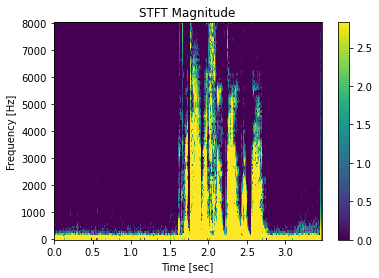

In [40]:
show_spec(16000, gold_fname)
IPython.display.Audio(gold_wav, rate=16000)

## モデルへの入力（8kHz へダウンサンプリング後に Cubic 補完した 16kHz）

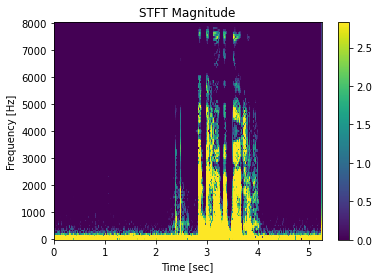

In [17]:
show_spec(16000, test_fname)
IPython.display.Audio(test_wav, rate=16000)

## 予測結果

True


2022-01-13 15:26:06.977204: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:26:06.994600: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:26:07.007137: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:26:07.018369: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:26:07.029650: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:26:07.040554: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:26:07.052014: E tensorflow/core/platform/default/subprocess.cc:212] Start cannot fork() child process: Cannot allocate memory
2022-01-13 15:26:07.

pred_sp.shape (658, 129)


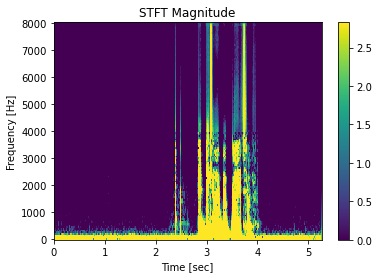

(129, 658)
658


In [18]:
pred_wav, pred_spec = pred_spec_2d(time_size=32, sp_size=129, net=model, magnitude=test_mag, angle=test_ang)
show_spec_data(freq_scale, time_scale, pred_spec)
print(pred_spec.shape)
print(len(time_scale))
IPython.display.Audio(pred_wav, rate=16000)

509


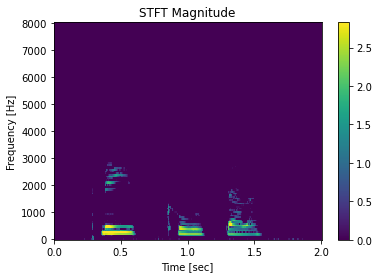

In [33]:
print(len(pred))
show_spec_data(freq_scale, np.linspace(0, 2, 509), np.array(pred).T)
#IPython.display.Audio(pred_wav, rate=16000)

In [19]:
pred = eval(open("pred.txt").read())

## Cubic 補完前の 8kHz の WAV

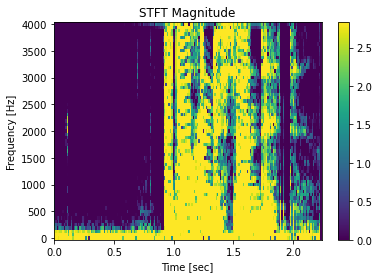

In [30]:
#fn = '/home/otya-ken/VCTK-Corpus/wav48/p376/p376_286.wav'
bn = os.path.basename(test_fname)
fn = f"/home/otya-ken/VCTK-Corpus/wav48/{bn.split('_')[0]}/{bn}"
with wave.open(fn) as wav:
    length = wav.getnframes() #16000*sec
    x = wav.readframes(wav.getnframes())
    wav_x = np.frombuffer(x, dtype = "int16")
    ds8k = down_sample_8000(wav_x)
    #ds8k = down_sample_8000_lpf(wav_x)
    up16k = upsampling2x(ds8k)
    
#-----------

show_spec_of_wav(8000, ds8k)
IPython.display.Audio(ds8k, rate=8000)

In [7]:
output = eval(open("output.txt").read())